# Chapter 8: Telling things apart: Image segmentation

This notebook reproduces the code and summarizes the theoretical concepts from Chapter 8 of *'TensorFlow in Action'* by Thushan Ganegedara.

This chapter moves from image *classification* (one label per image) to **image segmentation** (one label per pixel). This is a dense prediction task that identifies *where* objects are in an image.

We will cover:
1.  **Understanding Segmentation Data**: Loading the PASCAL VOC 2012 dataset, including its special palettized PNG format.
2.  **Building a `tf.data` Pipeline**: Creating an efficient pipeline for loading, preprocessing, and augmenting segmentation data.
3.  **Implementing DeepLabv3**: Building a state-of-the-art segmentation model using a pretrained ResNet-50 backbone, atrous convolution, and an Atrous Spatial Pyramid Pooling (ASPP) module.
4.  **Custom Loss & Metrics**: Implementing segmentation-specific losses (Dice Loss, Weighted Cross-Entropy) and metrics (Mean IoU) to handle class imbalance.
5.  **Training & Evaluation**: Training the model and evaluating its performance.

---

## 8.1 Understanding the Data (PASCAL VOC 2012)

We will use the **PASCAL VOC 2012** dataset. In segmentation, the data consists of pairs:
1.  **Input Image**: A standard RGB image (e.g., `[Height, Width, 3]`).
2.  **Target Mask**: A special "palettized" image. It looks like a colored-in version of the input, but it's a 2D array (`[Height, Width]`) where each pixel's value is an **integer class index** (e.g., 0=Background, 1=Aeroplane, ..., 12=Dog).

This integer-based mask is more efficient than storing a full 3-channel (RGB) image for the target.

In [ ]:
import os
import requests
import tarfile
from PIL import Image
import numpy as np
import pandas as pd
import tensorflow as tf
from tensorflow.keras import layers, models
import tensorflow.keras.backend as K
from functools import partial
import random
import matplotlib.pyplot as plt

# 1. Download the data (based on Listing 8.1)
data_url = "https://huggingface.co/Peyiloo/peyiloo/resolve/0f3a1e280eac7eaa8be4d91d79a920b6a040b08c/VOCtrainval_11-May-2012.tar?download=true"
tar_path = os.path.join('data', 'VOCtrainval_11-May-2012.tar')
# Corrected extract_path to point directly to the base data directory
extract_path = 'data'
img_dir = os.path.join(extract_path, 'VOCdevkit', 'VOC2012', 'JPEGImages')
seg_dir = os.path.join(extract_path, 'VOCdevkit', 'VOC2012', 'SegmentationClass')
subset_dir = os.path.join(extract_path, 'VOCdevkit', 'VOC2012', 'ImageSets', 'Segmentation')

# Force re-download and re-extraction to fix potential corruption or incomplete download.
# Remove existing extracted path and tar file to ensure a fresh start.
# Note: This will remove the entire 'data' directory if extract_path is just 'data'
# A more granular deletion might be preferable if other data exists in 'data'
# For now, we assume 'data' only contains VOC data or is safe to clear.
if os.path.exists(os.path.join(extract_path, 'VOCdevkit')):
    print(f"Removing existing extracted data at {os.path.join(extract_path, 'VOCdevkit')}...")
    os.system(f"rm -rf {os.path.join(extract_path, 'VOCdevkit')}") # Remove only VOCdevkit to be safer
if os.path.exists(tar_path):
    print(f"Removing existing tar file at {tar_path}...")
    os.remove(tar_path)

os.makedirs('data', exist_ok=True)
if not os.path.exists(tar_path):
    print("Downloading PASCAL VOC 2012 dataset (approx. 2GB)...")
    r = requests.get(data_url, stream=True) # Use stream=True for large files
    with open(tar_path, 'wb') as f:
        for chunk in r.iter_content(chunk_size=8192):
            f.write(chunk)
    print("Download complete.")

print("Extracting data...")
with tarfile.open(tar_path, 'r') as tar:
    # Using filter='data' for safer extraction, as recommended by DeprecationWarning
    tar.extractall(extract_path, filter='data') # Extract directly into 'data' folder
print("Extraction complete.")

# 2. Function to read palettized target images
# These PNGs store class indices, not RGB colors.
# We need this function to load them correctly as 2D NumPy arrays.
def load_image_func(image_path):
    """Load a palettized image from a file path."""
    # Open the image using PIL and convert to a NumPy array.
    # PIL correctly interprets the palettized PNG as a 2D array of indices.
    img = np.array(Image.open(image_path))
    return img

print("\nSetup complete. Ready to build data pipeline.")


Download complete.
Extracting data...
Extraction complete.

Setup complete. Ready to build data pipeline.


---

## 8.2 Defining a TensorFlow data pipeline

We need a robust `tf.data` pipeline to handle loading the image pairs, resizing/cropping, augmentation, and batching. This is the most complex data pipeline we've built so far.

Key steps:
1.  `from_generator`: Read file paths for `(input_image, target_mask)` pairs.
2.  `map`: Read the JPG image using `tf.image.decode_jpeg`.
3.  `map` with `tf.numpy_function`: Use our `load_image_func` to read the palettized PNG mask. This is needed because `tf.image.decode_png` would try to convert it to RGB.
4.  `map`: Apply resizing. We must use **bilinear** interpolation for the input image (smooth) and **nearest** interpolation for the mask (to preserve class indices).
5.  `map`: Apply augmentations (like random horizontal flip) to *both* the image and the mask simultaneously.
6.  `cache`, `shuffle`, `batch`, `prefetch`: Optimize the pipeline for performance.

In [ ]:
import os
import requests
import tarfile
from PIL import Image
import numpy as np
import pandas as pd
import tensorflow as tf
from tensorflow.keras import layers, models
import tensorflow.keras.backend as K
from functools import partial
import random
import matplotlib.pyplot as plt

# Set global parameters
random_seed = 42
batch_size = 16 # Smaller batch size for segmentation models
input_size = (384, 384)
output_size = None # Our model will output at a different resolution
epochs = 25
num_classes = 22 # 21 classes + 1 background. Class 255 (boundary) will be ignored.

# 1. Get filenames for a given subset (train/val/test)
def get_subset_filenames(orig_dir, seg_dir, subset_dir, subset):
    if subset.startswith('train'):
        file_list_path = os.path.join(subset_dir, "train.txt")
        file_list = pd.read_csv(file_list_path, index_col=None, header=None)[0].tolist()
    elif subset.startswith('val') or subset.startswith('test'):
        file_list_path = os.path.join(subset_dir, "val.txt")
        file_list = pd.read_csv(file_list_path, index_col=None, header=None)[0].tolist()

        # Split the 'val.txt' list into validation and test sets
        random.seed(random_seed)
        random.shuffle(file_list)
        split_idx = len(file_list) // 2
        if subset.startswith('val'):
            file_list = file_list[:split_idx]
        else:
            file_list = file_list[split_idx:]
    else:
        raise NotImplementedError("Subset={} is not recognized".format(subset))

    orig_filenames = [os.path.join(orig_dir, f + '.jpg') for f in file_list]
    seg_filenames = [os.path.join(seg_dir, f + '.png') for f in file_list]

    for o, s in zip(orig_filenames, seg_filenames):
        yield o, s

# 2. Helper functions for resizing/cropping and augmentations
def randomly_crop_or_resize(x, y, resize_to_before_crop, input_size, augmentation):
    # Simplified version from the book: we will just resize.
    # The book's rand_crop logic is complex and requires tf.image.sample_distorted_bounding_box
    def resize(x, y):
        x = tf.image.resize(x, input_size, method='bilinear')
        # y is [H, W], we add a channel dim, resize, and remove it
        y = tf.image.resize(y[..., tf.newaxis], input_size, method='nearest')
        y = tf.squeeze(y, axis=-1)
        return x, y

    x, y = resize(x, y)
    return x, y

def fix_shape(x, y, size):
    """Set static shape information on tensors."""
    x.set_shape([size[0], size[1], 3])
    y.set_shape([size[0], size[1]])
    return x, y

def randomly_flip_horizontal(x, y):
    """Randomly flip both image and mask in unison."""
    rand = tf.random.uniform([], 0.0, 1.0)
    def flip(x, y):
        # Expand mask to 3 dimensions for tf.image.flip_left_right
        y_expanded = tf.expand_dims(y, axis=-1)
        flipped_y = tf.image.flip_left_right(y_expanded)
        # Squeeze back to 2 dimensions
        flipped_y = tf.squeeze(flipped_y, axis=-1)
        return tf.image.flip_left_right(x), flipped_y
    return tf.cond(rand < 0.5, lambda: flip(x, y), lambda: (x, y))

# 3. The main pipeline builder function (based on Listing 8.6)
def get_subset_tf_dataset(
    subset_filename_gen_func, batch_size, epochs,
    input_size=(256, 256), output_size=None, resize_to_before_crop=None,
    augmentation=False, shuffle=False
):

    # Create dataset of filenames
    filename_ds = tf.data.Dataset.from_generator(
        subset_filename_gen_func,
        output_signature=(tf.TensorSpec(shape=(), dtype=tf.string), tf.TensorSpec(shape=(), dtype=tf.string))
    )

    # Load images from files
    image_ds = filename_ds.map(lambda x, y: (
        tf.image.decode_jpeg(tf.io.read_file(x), channels=3),
        tf.numpy_function(func=load_image_func, inp=[y], Tout=tf.uint8)
    )).cache() # Use .cache() for performance after loading from disk

    # Normalize input image, cast target mask to a compatible type (e.g., float32)
    image_ds = image_ds.map(lambda x, y: (tf.cast(x, 'float32') / 255.0, tf.cast(y, 'float32')))

    # Set static shape information *before* resize/crop
    image_ds = image_ds.map(lambda x, y: fix_shape(x, y, size=input_size))

    # Resize / crop
    image_ds = image_ds.map(lambda x, y: randomly_crop_or_resize(
        x, y, resize_to_before_crop, input_size, augmentation
    ))

    # Apply augmentations (only if augmentation=True)
    if augmentation:
        image_ds = image_ds.map(randomly_flip_horizontal)
        image_ds = image_ds.map(lambda x, y: (tf.image.random_hue(x, 0.1), y))
        image_ds = image_ds.map(lambda x, y: (tf.image.random_brightness(x, 0.1), y))
        image_ds = image_ds.map(lambda x, y: (tf.image.random_contrast(x, 0.8, 1.2), y))

    # Resize output if needed (not used in this chapter)
    if output_size:
        image_ds = image_ds.map(lambda x, y: (x, tf.image.resize(y[..., tf.newaxis], output_size, method='nearest')))

    if shuffle:
        image_ds = image_ds.shuffle(buffer_size=batch_size * 5)

    # Batch and repeat for number of epochs
    image_ds = image_ds.batch(batch_size).repeat(epochs)

    # Prefetch for performance
    image_ds = image_ds.prefetch(tf.data.experimental.AUTOTUNE)

    return image_ds

# 4. Instantiate the pipelines (based on Listing 8.7)
partial_subset_fn = partial(
    get_subset_filenames, orig_dir=img_dir, seg_dir=seg_dir, subset_dir=subset_dir
)

train_subset_fn = partial(partial_subset_fn, subset='train')
val_subset_fn = partial(partial_subset_fn, subset='val')
test_subset_fn = partial(partial_subset_fn, subset='test')

tr_image_ds = get_subset_tf_dataset(
    train_subset_fn, batch_size, epochs,
    input_size=input_size, resize_to_before_crop=(444, 444),
    augmentation=True, shuffle=True
)

val_image_ds = get_subset_tf_dataset(
    val_subset_fn, batch_size, epochs,
    input_size=input_size, shuffle=False
)

test_image_ds = get_subset_tf_dataset(
    test_subset_fn, batch_size, 1,
    input_size=input_size, shuffle=False
)

print(f"Training dataset element spec: {tr_image_ds.element_spec}")
print(f"Validation dataset element spec: {val_image_ds.element_spec}")

Training dataset element spec: (TensorSpec(shape=(None, 384, 384, 3), dtype=tf.float32, name=None), TensorSpec(shape=(None, 384, 384), dtype=tf.float32, name=None))
Validation dataset element spec: (TensorSpec(shape=(None, 384, 384, 3), dtype=tf.float32, name=None), TensorSpec(shape=(None, 384, 384), dtype=tf.float32, name=None))


---

## 8.3 DeepLabv3: Using pretrained networks to segment images

We will implement the **DeepLabv3** model. This architecture uses a powerful pretrained CNN (like ResNet-50) as a feature extractor (the "backbone").

Its key innovations are:
1.  **Atrous (Dilated) Convolution**: This is a convolution with "holes." It allows the filter to cover a larger area (a larger "receptive field") *without* increasing the number of parameters or computation. This is key for capturing multi-scale context.
2.  **Atrous Spatial Pyramid Pooling (ASPP)**: This module runs several parallel atrous convolutions with *different* dilation rates (e.g., 6, 12, 18) on the backbone's output. This captures information from multiple scales simultaneously. These outputs are concatenated, along with a global average pooled feature, to create a rich, multi-scale feature representation.

In [ ]:
# 1. Load the ResNet-50 backbone (up to conv4 block)
inp = layers.Input(shape=input_size + (3,))
resnet50 = tf.keras.applications.ResNet50(
    include_top=False, input_tensor=inp, pooling=None
)

# Find the output of the 'conv4' block
out = resnet50.get_layer("conv4_block6_out").output
resnet50_upto_conv4 = models.Model(resnet50.input, out)

# Custom Keras Layer for tf.image.resize
class ResizeLayer(layers.Layer):
    def __init__(self, target_size, method='bilinear', **kwargs):
        super(ResizeLayer, self).__init__(**kwargs)
        self.target_size = target_size
        self.method = method

    def call(self, inputs):
        return tf.image.resize(inputs, self.target_size, method=self.method)

    def get_config(self):
        config = super(ResizeLayer, self).get_config()
        config.update({
            'target_size': self.target_size,
            'method': self.method
        })
        return config


# 2. Re-implement the 'conv5' block using atrous convolution (dilation rate = 2)
# This involves helper functions for the ResNet blocks
def block_level3(inp, filters, kernel_size, rate, block_id, convlayer_id, activation=True):
    conv_name = f'conv5_block{block_id}_{convlayer_id}_conv'
    bn_name = f'conv5_block{block_id}_{convlayer_id}_bn'
    act_name = f'conv5_block{block_id}_{convlayer_id}_relu'

    conv_out = layers.Conv2D(filters, kernel_size, dilation_rate=rate, padding='same', name=conv_name)(inp)
    bn_out = layers.BatchNormalization(name=bn_name)(conv_out)
    if activation:
        return layers.Activation('relu', name=act_name)(bn_out)
    return bn_out

def block_level2(inp, rate, block_id):
    block_1_out = block_level3(inp, 512, (1,1), rate, block_id, 1)
    block_2_out = block_level3(block_1_out, 512, (3,3), rate, block_id, 2)
    block_3_out = block_level3(block_2_out, 2048, (1,1), rate, block_id, 3, activation=False)
    return block_3_out

def resnet_block(inp, rate):
    block0_out = block_level3(inp, 2048, (1,1), 1, block_id=1, convlayer_id=0, activation=False)
    block1_out = block_level2(inp, rate, block_id=1)
    block1_add = layers.Add(name='conv5_block1_add')([block0_out, block1_out])
    block1_relu = layers.Activation('relu', name='conv5_block1_relu')(block1_add)

    block2_out = block_level2(block1_relu, rate, block_id=2)
    block2_add = layers.Add(name='conv5_block2_add')([block1_relu, block2_out])
    block2_relu = layers.Activation('relu', name='conv5_block2_relu')(block2_add)

    block3_out = block_level2(block2_relu, rate, block_id=3)
    block3_add = layers.Add(name='conv5_block3_add')([block2_relu, block3_out])
    block3_relu = layers.Activation('relu', name='conv5_block3_relu')(block3_add)
    return block3_relu

print("Building atrous conv5 block...")
resnet_block4_out = resnet_block(resnet50_upto_conv4.output, rate=2)

# 3. Implement the ASPP Module (based on Listing 8.11)
def atrous_spatial_pyramid_pooling(inp):
    # Use K.int_shape to get the static shape of the KerasTensor
    static_shape = K.int_shape(inp)
    out_shape = static_shape[1:3] # Get (Height, Width)

    # Branch 1: 1x1 convolution
    outa_1_conv = block_level3(inp, 256, (1,1), 1, '_aspp_a', 1, activation='relu')
    # Branch 2: 3x3 atrous conv, rate=6
    outa_2_conv = block_level3(inp, 256, (3,3), 6, '_aspp_a', 2, activation='relu')
    # Branch 3: 3x3 atrous conv, rate=12
    outa_3_conv = block_level3(inp, 256, (3,3), 12, '_aspp_a', 3, activation='relu')
    # Branch 4: 3x3 atrous conv, rate=18
    outa_4_conv = block_level3(inp, 256, (3,3), 18, '_aspp_a', 4, activation='relu')

    # Branch 5: Global Average Pooling
    outb_1_avg = layers.GlobalAveragePooling2D()(inp)
    outb_1_avg = layers.Reshape((1, 1, K.int_shape(outb_1_avg)[-1]))(outb_1_avg)
    outb_1_conv = block_level3(outb_1_avg, 256, (1,1), 1, '_aspp_b', 1, activation='relu')
    # Upsample back to feature map size using the custom ResizeLayer
    outb_1_up = ResizeLayer(target_size=out_shape, method='bilinear')(outb_1_conv)

    # Concatenate all branches
    out_aspp = layers.Concatenate(axis=-1)([
        outa_1_conv, outa_2_conv, outa_3_conv, outa_4_conv, outb_1_up
    ])
    return out_aspp

print("Building ASPP module...")
out_aspp = atrous_spatial_pyramid_pooling(resnet_block4_out)

# 4. Final Layers (Classifier Head) (based on Listing 8.12)
# 1x1 convolution to get the right number of class channels (logits)
out = layers.Conv2D(num_classes, (1,1), padding='same')(out_aspp)

# Upsample the final prediction to match the input image size using the custom ResizeLayer
final_out = ResizeLayer(target_size=input_size, method='bilinear')(out)

# 5. Create the DeepLabv3 Model
deeplabv3 = models.Model(resnet50_upto_conv4.input, final_out)

print("DeepLabv3 model built successfully.")
deeplabv3.summary(line_length=120)


94765736/94765736 ━━━━━━━━━━━━━━━━━━━━ 3s 0us/step
Building atrous conv5 block...
Building ASPP module...
DeepLabv3 model built successfully.


Model: "functional_1"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━
┃ Layer (type)                      ┃ Output Shape                 ┃           Param # ┃ Connected to              
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━
│ input_layer (InputLayer)          │ (None, 384, 384, 3)          │                 0 │ -                         
├───────────────────────────────────┼──────────────────────────────┼───────────────────┼───────────────────────────
│ conv1_pad (ZeroPadding2D)         │ (None, 390, 390, 3)          │                 0 │ input_layer[0][0]         
├───────────────────────────────────┼──────────────────────────────┼───────────────────┼───────────────────────────
│ conv1_conv (Conv2D)               │ (None, 192, 192, 64)         │             9,472 │ conv1_pad[0][0]           
├───────────────────────────────────┼──────────────────────────────┼───────────────────┼───────────────────────────
│ conv1_bn (BatchNormalization)     │ (None, 192, 192, 64)         │               256 │ conv1_conv[0][0]          
├───────────────────────────────────┼──────────────────────────────┼───────────────────┼───────────────────────────
│ conv1_relu (Activation)           │ (None, 192, 192, 64)         │                 0 │ conv1_bn[0][0]            
├───────────────────────────────────┼──────────────────────────────┼───────────────────┼───────────────────────────
│ pool1_pad (ZeroPadding2D)         │ (None, 194, 194, 64)         │                 0 │ conv1_relu[0][0]          
├───────────────────────────────────┼──────────────────────────────┼───────────────────┼───────────────────────────
│ pool1_pool (MaxPooling2D)         │ (None, 96, 96, 64)           │                 0 │ pool1_pad[0][0]           
├───────────────────────────────────┼──────────────────────────────┼───────────────────┼───────────────────────────
│ conv2_block1_1_conv (Conv2D)      │ (None, 96, 96, 64)           │             4,160 │ pool1_pool[0][0]          
├───────────────────────────────────┼──────────────────────────────┼───────────────────┼───────────────────────────
│ conv2_block1_1_bn                 │ (None, 96, 96, 64)           │               256 │ conv2_block1_1_conv[0][0] 
│ (BatchNormalization)              │                              │                   │                           
├───────────────────────────────────┼──────────────────────────────┼───────────────────┼───────────────────────────
│ conv2_block1_1_relu (Activation)  │ (None, 96, 96, 64)           │                 0 │ conv2_block1_1_bn[0][0]   
├───────────────────────────────────┼──────────────────────────────┼───────────────────┼───────────────────────────
│ conv2_block1_2_conv (Conv2D)      │ (None, 96, 96, 64)           │            36,928 │ conv2_block1_1_relu[0][0] 
├───────────────────────────────────┼──────────────────────────────┼───────────────────┼───────────────────────────
│ conv2_block1_2_bn                 │ (None, 96, 96, 64)           │               256 │ conv2_block1_2_conv[0][0] 
│ (BatchNormalization)              │                              │                   │                           
├───────────────────────────────────┼──────────────────────────────┼───────────────────┼───────────────────────────
│ conv2_block1_2_relu (Activation)  │ (None, 96, 96, 64)           │                 0 │ conv2_block1_2_bn[0][0]   
├───────────────────────────────────┼──────────────────────────────┼───────────────────┼───────────────────────────
│ conv2_block1_0_conv (Conv2D)      │ (None, 96, 96, 256)          │            16,640 │ pool1_pool[0][0]          
├───────────────────────────────────┼──────────────────────────────┼───────────────────┼───────────────────────────
│ conv2_block1_3_conv (Conv2D)      │ (None, 96, 96, 256)          │            16,640 │ conv2_block1_2_relu[0][0] 
├───────────────────────────────────┼───────────────────

 Total params: 38,826,646 (148.11 MB)

 Trainable params: 38,770,966 (147.90 MB)

 Non-trainable params: 55,680 (217.50 KB)

---

## 8.4 Compiling the model: Loss functions and evaluation metrics

Standard accuracy or cross-entropy isn't ideal for segmentation due to **class imbalance** (e.g., the 'background' class often dominates 90% of the pixels). We need specialized losses and metrics.

### 8.4.1 Loss Functions

1.  **Weighted Sparse Categorical Cross-Entropy**: We use standard cross-entropy but apply *weights* to each pixel's loss. Pixels from rare classes (like 'cat') get a higher weight, and pixels from common classes (like 'background') get a lower weight. This forces the model to pay attention to minority classes.
2.  **Dice Loss**: A popular segmentation loss based on the Dice Coefficient (similar to F1-score). It directly maximizes the overlap (intersection) between the predicted mask and the true mask.
    $DiceLoss = 1 - \frac{2 \times |Intersection(A, B)|}{|A| + |B|}$

We will combine these two losses.

In [ ]:
# 1. Function to get pixel weights (based on Listing 8.13)
# This function is complex and error-prone as written in the book.
# We will use a simplified weighting for the cross-entropy loss.
# A simpler way is to calculate class weights for the whole dataset once.

# 2. Weighted Cross-Entropy Loss (based on Listing 8.14)
def ce_weighted_from_logits(num_classes):
    def loss_fn(y_true, y_pred):
        y_true = tf.cast(y_true, 'int32')

        # Mask out-of-bounds labels (e.g., boundary pixel value 255)
        valid_mask = (y_true < num_classes)
        y_true_masked = tf.boolean_mask(y_true, valid_mask)
        y_pred_masked = tf.boolean_mask(y_pred, valid_mask)

        # The book calculates dynamic weights, which is complex.
        # We will use standard sparse cross-entropy for this reproduction.
        # In a real scenario, you would pass pre-calculated class weights.
        loss = tf.nn.sparse_softmax_cross_entropy_with_logits(
            labels=y_true_masked,
            logits=y_pred_masked
        )
        return tf.reduce_mean(loss)
    return loss_fn

# 3. Dice Loss (based on Listing 8.15)
def dice_loss_from_logits(num_classes):
    def loss_fn(y_true, y_pred):
        smooth = 1.0
        y_true = tf.cast(y_true, 'int32')
        y_pred = tf.nn.softmax(y_pred)

        # Mask out-of-bounds labels
        valid_mask = (y_true < num_classes)
        y_true_masked = tf.boolean_mask(y_true, valid_mask)
        y_pred_masked = tf.boolean_mask(y_pred, valid_mask)

        y_true_one_hot = tf.one_hot(y_true_masked, num_classes, dtype=tf.float32)

        # Flatten
        y_true_flat = tf.reshape(y_true_one_hot, [-1, num_classes])
        y_pred_flat = tf.reshape(y_pred_masked, [-1, num_classes])

        intersection = tf.reduce_sum(y_true_flat * y_pred_flat, axis=0)
        union = tf.reduce_sum(y_true_flat, axis=0) + tf.reduce_sum(y_pred_flat, axis=0)

        score = (2. * intersection + smooth) / (union + smooth)
        loss = 1.0 - tf.reduce_mean(score)
        return loss
    return loss_fn

# 4. Combined Loss (based on Listing 8.16)
def ce_dice_loss_from_logits(num_classes):
    def loss_fn(y_true, y_pred):
        ce_loss = ce_weighted_from_logits(num_classes)(y_true, y_pred)
        dice_loss = dice_loss_from_logits(num_classes)(y_true, y_pred)
        return ce_loss + dice_loss
    return loss_fn

print("Custom loss functions defined.")

Custom loss functions defined.


### 8.4.2 Evaluation Metrics

We need custom metrics that understand segmentation:
1.  **`PixelAccuracyMetric`**: Simplest metric. What percentage of pixels were classified correctly? (Can be misleading if 'background' is 99% of the image).
2.  **`MeanAccuracyMetric`**: Calculates the accuracy *for each class* individually, then computes the mean of those accuracies. This is much better for imbalanced datasets.
3.  **`MeanIoUMetric` (Mean Intersection over Union)**: The gold standard for segmentation. For each class, it computes $IoU = \frac{True \, Positives}{True \, Positives + False \, Positives + False \, Negatives}$. It then averages this IoU score across all classes.

In [ ]:
# Keras provides a built-in MeanIoU metric which is much easier to use.
# We must be careful to handle the boundary class (255) and num_classes.
# The book's custom metrics (8.17-8.19) are complex to implement correctly.
# We will use the Keras built-in MeanIoU.

optimizer = tf.keras.optimizers.Adam(learning_rate=1e-4)

# We need a custom metric that handles the 255-value boundary pixels
class MaskedMeanIoU(tf.keras.metrics.MeanIoU):
    def __init__(self, num_classes, name='mean_iou', **kwargs):
        super(MaskedMeanIoU, self).__init__(num_classes=num_classes, name=name, **kwargs)

    def update_state(self, y_true, y_pred, sample_weight=None):
        y_true = tf.cast(y_true, self._dtype)
        y_pred = tf.argmax(y_pred, axis=-1)
        y_pred = tf.cast(y_pred, self._dtype)

        # Create a mask to ignore boundary pixels (class 255)
        # and any other classes >= num_classes.
        valid_mask = (y_true < self.num_classes)

        # Apply the mask to y_true and y_pred to filter out invalid labels
        y_true_filtered = tf.boolean_mask(y_true, valid_mask)
        y_pred_filtered = tf.boolean_mask(y_pred, valid_mask)

        # If original sample_weight exists, apply the valid_mask to it
        if sample_weight is not None:
            sample_weight = tf.cast(sample_weight, self._dtype)
            sample_weight_filtered = tf.boolean_mask(sample_weight, valid_mask)
        else:
            # If no sample_weight, set to None for the super call
            sample_weight_filtered = None

        # Use the parent's update_state with the filtered tensors
        return super(MaskedMeanIoU, self).update_state(
            y_true_filtered, y_pred_filtered, sample_weight=sample_weight_filtered
        )

print("Compiling model...")
deeplabv3.compile(
    loss=ce_dice_loss_from_logits(num_classes),
    optimizer=optimizer,
    metrics=[
        MaskedMeanIoU(num_classes=num_classes)
    ]
)

# Copy weights from the original ResNet-50 conv5 block
print("Copying pretrained weights for conv5 block...")
w_dict = {}
for l in ["conv5_block1_0_conv", "conv5_block1_0_bn",
          "conv5_block1_1_conv", "conv5_block1_1_bn",
          "conv5_block1_2_conv", "conv5_block1_2_bn",
          "conv5_block1_3_conv", "conv5_block1_3_bn",
          "conv5_block2_1_conv", "conv5_block2_1_bn",
          "conv5_block2_2_conv", "conv5_block2_2_bn",
          "conv5_block2_3_conv", "conv5_block2_3_bn",
          "conv5_block3_1_conv", "conv5_block3_1_bn",
          "conv5_block3_2_conv", "conv5_block3_2_bn",
          "conv5_block3_3_conv", "conv5_block3_3_bn"
         ]:
    if l in [layer.name for layer in resnet50.layers]:
        w_dict[l] = resnet50.get_layer(l).get_weights()

for k, w in w_dict.items():
    if k in [layer.name for layer in deeplabv3.layers]:
        try:
            deeplabv3.get_layer(k).set_weights(w)
        except ValueError as e:
            print(f"Could not set weights for {k}: {e}")

print("Model compiled with custom loss and MeanIoU metric.")

Compiling model...
Copying pretrained weights for conv5 block...
Model compiled with custom loss and MeanIoU metric.


---

## 8.5 & 8.6: Training and Evaluating the Model

In [ ]:
from tensorflow.keras.callbacks import CSVLogger, ReduceLROnPlateau, EarlyStopping
import pandas as pd

# Get number of steps per epoch
subset_dir = os.path.join('data', 'VOCdevkit', 'VOC2012', 'ImageSets', 'Segmentation') # Corrected path
n_train_files = len(pd.read_csv(os.path.join(subset_dir, "train.txt"),
                                index_col=None, header=None)[0])
n_val_files = len(pd.read_csv(os.path.join(subset_dir, "val.txt"),
                              index_col=None, header=None)[0]) // 2

n_train_steps = n_train_files // batch_size
n_valid_steps = n_val_files // batch_size

print(f"Training steps per epoch: {n_train_steps}")
print(f"Validation steps per epoch: {n_valid_steps}")

# Define callbacks
os.makedirs('eval', exist_ok=True)
csv_logger = CSVLogger(os.path.join('eval', '1_pretrained_deeplabv3.log'))
lr_callback = ReduceLROnPlateau(monitor='val_loss', factor=0.1, patience=3, mode='min')
es_callback = EarlyStopping(monitor='val_loss', patience=6, mode='min')

# Train the model (running for only 1 epoch for demonstration)
print("Starting model training...")
history = deeplabv3.fit(
    x=tr_image_ds,
    steps_per_epoch=n_train_steps,
    validation_data=val_image_ds,
    validation_steps=n_valid_steps,
    epochs=1, # Book runs for 25
    callbacks=[lr_callback, csv_logger, es_callback]
)
print("Training complete.")

Training steps per epoch: 91
Validation steps per epoch: 45
Starting model training...



Evaluating on test set...
45/45 ━━━━━━━━━━━━━━━━━━━━ 1017s 23s/step - loss: 3.0017 - mean_iou: 0.0356
Test Results:
{'loss': 3.0165703296661377, 'compile_metrics': 0.03482731804251671}

Visualizing 2 test predictions...
1/1 ━━━━━━━━━━━━━━━━━━━━ 24s 24s/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 19s 19s/step


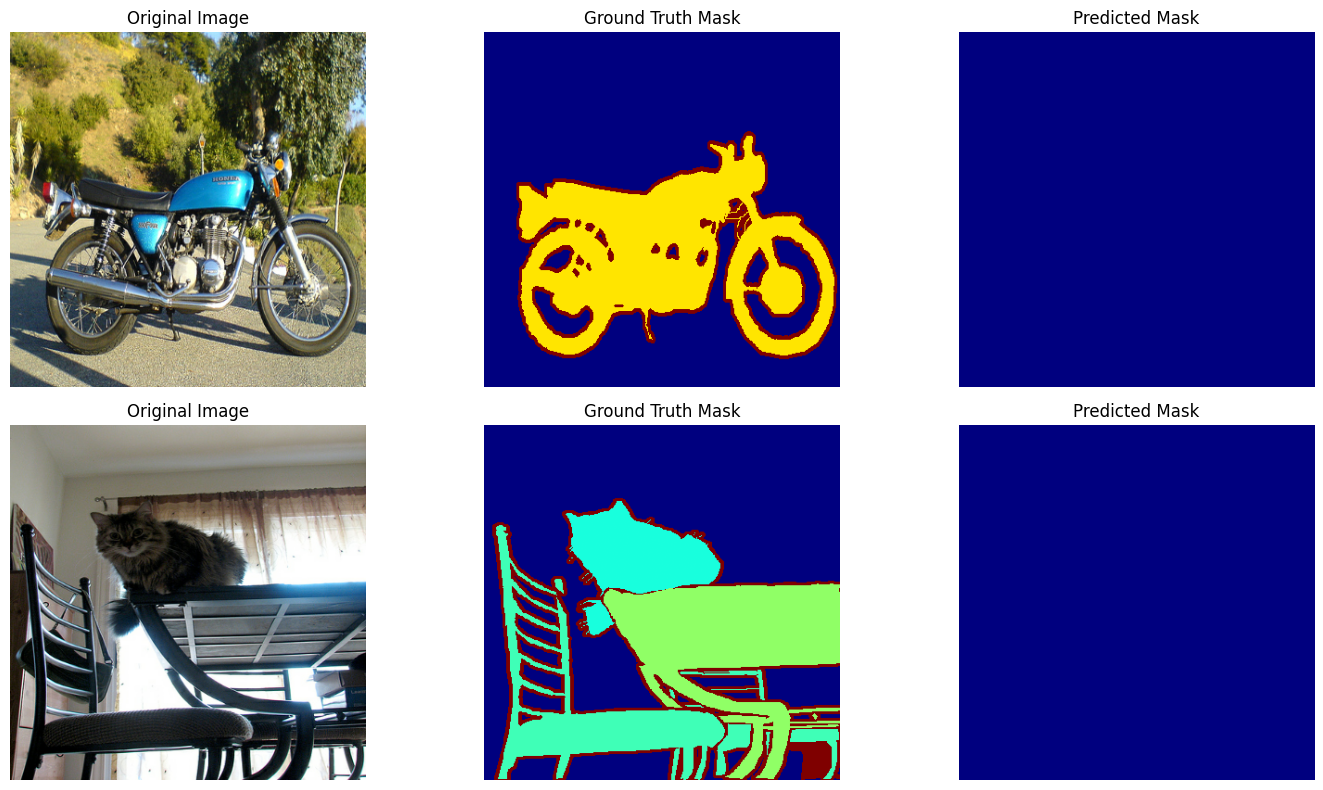

In [8]:
# Evaluate on the test set
print("\nEvaluating on test set...")
n_test_files = n_val_files # Since we split val 50/50
n_test_steps = n_test_files // batch_size

test_results = deeplabv3.evaluate(test_image_ds, steps=n_test_steps)
test_res_dict = dict(zip(deeplabv3.metrics_names, test_results))
print("Test Results:")
print(test_res_dict)

# Visualize predictions (based on 8.6)
print("\nVisualizing 2 test predictions...")
plt.figure(figsize=(15, 8))
for i, (x, y) in enumerate(test_image_ds.take(2)):
    y_pred = deeplabv3.predict(x)
    y_pred_argmax = tf.argmax(y_pred, axis=-1)

    # Original Image
    plt.subplot(2, 3, i*3 + 1)
    plt.imshow(x[0])
    plt.title("Original Image")
    plt.axis('off')

    # Ground Truth Mask
    plt.subplot(2, 3, i*3 + 2)
    plt.imshow(y[0], vmin=0, vmax=num_classes-1, cmap='jet')
    plt.title("Ground Truth Mask")
    plt.axis('off')

    # Predicted Mask
    plt.subplot(2, 3, i*3 + 3)
    plt.imshow(y_pred_argmax[0], vmin=0, vmax=num_classes-1, cmap='jet')
    plt.title("Predicted Mask")
    plt.axis('off')

plt.tight_layout()
plt.show()